<a href="https://colab.research.google.com/github/CrMessiSuriJr/ai-face-recognition/blob/master/resnet_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
# @markdown Installing required files/libraries and updating previously intsalled
!pip install --upgrade torch torchvision Pillow matplotlib scikit-image sklearn
!pip install captum lime

  Using cached Pillow-10.1.0-cp310-cp310-manylinux_2_28_x86_64.whl (3.6 MB)
  Using cached matplotlib-3.8.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
  Using cached scikit_image-0.22.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (14.7 MB)
  Using cached sklearn-0.0.post10.tar.gz (3.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [36]:
# @markdown Importing libraries: torch, os, random, shutil, google.colab, PIL, matplotlib, Install&Import captum etc...
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import datasets, models
import os
import random
import shutil
from google.colab import drive
from PIL import Image
import matplotlib.pyplot as plt

import captum.attr as captum_attr
from captum.attr import GuidedGradCam

import numpy as np
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries
from lime.lime_image import LimeImageExplainer

from sklearn.manifold import TSNE

from PIL import UnidentifiedImageError

In [37]:
# Define data preprocessing and augmentation
dim = 256 # @param {type:"integer"}
crop_dim = 224 # @param {type:"integer"}
norm_mean = [0.0]*3
norm_std = [0.0]*3
norm_mean[0] = 0.485 # @param
norm_mean[1] = 0.456 # @param
norm_mean[2] = 0.406 # @param
norm_std[0] = 0.229 # @param
norm_std[1] = 0.224 # @param
norm_std[2] = 0.225 # @param
transform = transforms.Compose([
    transforms.Resize((dim, dim)),  # Resize images to a fixed size
    transforms.CenterCrop(crop_dim),     # Center crop to 224x224 pixels
    transforms.ToTensor(),          # Convert to PyTorch tensor
    transforms.Normalize(mean=norm_mean, std=norm_std)  # Normalize
])


In [38]:
drive.mount('/content/drive')

# @markdown Set the path to your Kaggle API key in Google Drive
kaggle_api_key_path = "/content/kaggle/kaggle.json" # @param {type:"string"}
# @markdown ^^^The folder containing kaggle.json api file, in Google-drive for file persistence

# @markdown Copy the Kaggle API key to the required directory
!mkdir -p ~/.kaggle
!cp "$kaggle_api_key_path" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
# @markdown Importing kaggle for api access for dataset download
import kaggle

# @markdown Replace 'your_dataset_folder' with the Kaggle dataset name
dataset_name = 'emmarex/plantdisease' # @param {type:"string"}

# @markdown Define the dataset path
dataset_path = '/content' # @param {type:"string"}

# @markdown Download the dataset using Kaggle API
to_download_data = True # @param {type:"boolean"}
if (to_download_data): kaggle.api.dataset_download_files(dataset_name, unzip=True, path = dataset_path)  # Download and unzip the dataset to the './data' directory



In [40]:
# @markdown Define the ratio for the train-test split
split_ratio = 0.7  # 70% for training, 30% for testing

# @markdown Specify the path to your dataset on Google Drive
drive_dataset_path = "/PlantVillage" # @param {type:"string"}
drive_dataset_path = dataset_path + drive_dataset_path

# @markdown List all the class folders in your dataset directory
class_folders = os.listdir(drive_dataset_path)

# @markdown Create train and test directories if they don't exist
base_dir = dataset_path # @param {type:"string"}

train_dir = base_dir + "/train" # @markdown train_dir = base_dir + "/train"

test_dir = base_dir + "/test" # @markdown test_dir = base_dir + "/test"

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


# @markdown Function to check if an image can be opened without errors
def is_valid_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()
        return True
    except Exception as e:
        return False

# @markdown Iterate through each class folder
for class_folder in class_folders:
    class_path = os.path.join(drive_dataset_path, class_folder)

    # @markdown List all the image files in the current class folder
    all_files = os.listdir(class_path)

    # @markdown Randomly shuffle the list of files
    random.shuffle(all_files)

    # @markdown Calculate the number of files for training and testing within the current class
    num_total_files = len(all_files)
    num_train_files = int(split_ratio * num_total_files)
    num_test_files = num_total_files - num_train_files

    # @markdown Create train and test subdirectories within the class folder
    class_train_dir = os.path.join(train_dir, class_folder)
    class_test_dir = os.path.join(test_dir, class_folder)
    os.makedirs(class_train_dir, exist_ok=True)
    os.makedirs(class_test_dir, exist_ok=True)

    # @markdown Move the first num_train_files files to the train subdirectory and the rest to the test subdirectory
    for i, file_name in enumerate(all_files):
        source_path = os.path.join(class_path, file_name)
        if i < num_train_files and is_valid_image(source_path):
            destination_path = os.path.join(class_train_dir, file_name)
        else:
          if is_valid_image(source_path):
            destination_path = os.path.join(class_test_dir, file_name)
        shutil.copy(source_path, destination_path)

In [47]:
# @markdown Create ImageFolder datasets for training and testing
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# @markdown Define batch size and number of workers for data loading
batch_size = 96
num_workers = 8

# @markdown Create a DataLoader for the training dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# @markdown Print the class names (based on folder names)
class_names = train_dataset.classes
print("Class names:", class_names)

# @markdown Print the number of samples in the training and testing sets
print("Number of training samples:", len(train_dataset))
print("Number of testing samples:", len(test_dataset))

# @markdown Iterate through your dataset and check each image
for class_folder in class_folders:
    class_path = os.path.join(drive_dataset_path, class_folder)
    for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)

        try:
            if not is_valid_image(image_path):
                print(f"Invalid image: {image_path}")
                os.remove(image_path)
                # Handle or remove the problematic image if needed
        except UnidentifiedImageError as e:
            print(f"Unidentified image error: {image_path}")
            os.remove(image_path)
            print(e)  # Print the error message


Class names: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Number of training samples: 20102
Number of testing samples: 13599


In [42]:
# Continue with your training loop and data loading using train_loader
for batch in train_loader:
    inputs, labels = batch

In [50]:
# Continue with your training loop and data loading using test_loader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
for batch in test_loader:
    inputs, labels = batch

In [46]:
# @markdown (DEPRECATED) error causing file removal
file_name = "/content/test/Tomato__Tomato_YellowLeaf__Curl_Virus/6dfd3bf5-7b49-42e8-aed8-28d36cb980ff___YLCV_GCREC 1959.JPG" # @param {type:"string"}
to_delete = True # @param {type:"boolean"}
if (to_delete):
    !rm "$file_name"

In [48]:
# @markdown Define the ResNet model
class ResNet(nn.Module):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        # @markdown Define the ResNet architecture here (e.g., ResNet-18, ResNet-50)
        self.resnet = models.resnet50(pretrained=True)  # Use models.resnet50
        # @markdown Modify the last layer for your specific number of classes
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [49]:
# @markdown Initialize the model
num_classes = len(train_dataset.classes)
model = ResNet(num_classes)

In [51]:
# @markdown Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
lr = 0.001 # @param
optimizer = optim.Adam(model.parameters(), lr=lr)

In [52]:
# @markdown Training loop
num_epochs = 10 # @param {type:"integer"}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}')


Epoch 1/10, Loss: 0.3159203066712334
Epoch 2/10, Loss: 0.12245706319365474
Epoch 3/10, Loss: 0.09102306185024125
Epoch 4/10, Loss: 0.06409525423133303
Epoch 5/10, Loss: 0.06881533345163224
Epoch 6/10, Loss: 0.053972480418382304
Epoch 7/10, Loss: 0.035582014823531995
Epoch 8/10, Loss: 0.026697350979693942
Epoch 9/10, Loss: 0.0342328963892734
Epoch 10/10, Loss: 0.04558192790164391


In [53]:
# @markdown Evaluation
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {100 * correct / total}%')

Accuracy on test set: 96.49238914626075%


<Figure size 1000x800 with 0 Axes>

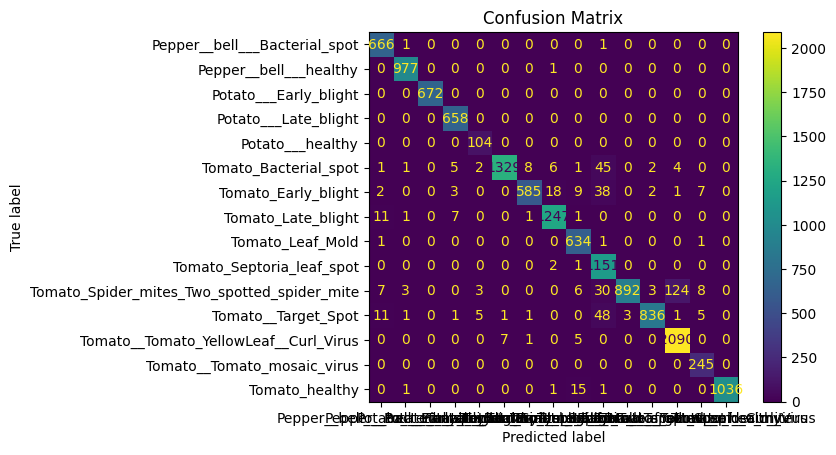

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# @markdown Get true labels and predicted labels
true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# @markdown Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=range(num_classes))

# @markdown Plot the confusion matrix
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes).plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix')
plt.show()

/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


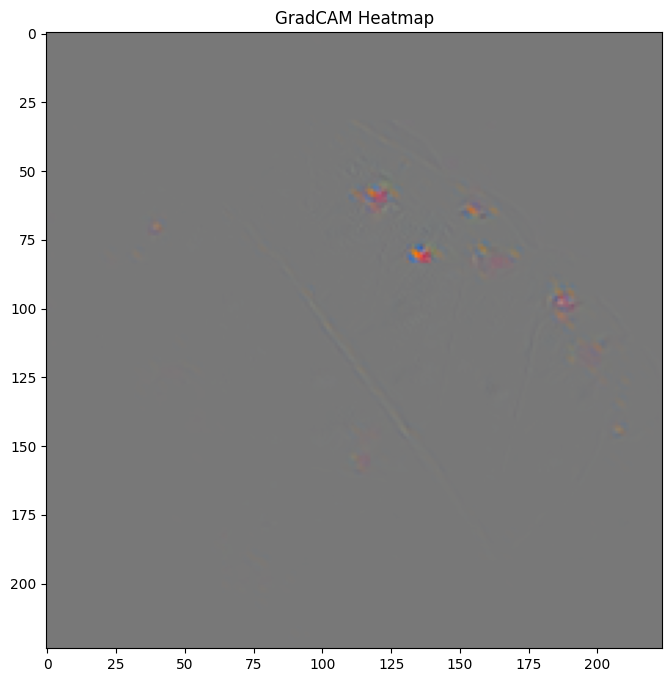

In [55]:
# @markdown Load the test dataset
reload_test_data = False # @param {type:"boolean"}
if (reload_test_data):
    test_dataset = datasets.ImageFolder(test_dir, transform=transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]))

# @markdown Define a function to compute GradCAM
def compute_gradcam(input_image, target_class):
    model.eval()
    input_image = input_image.to(device)
    target_class = torch.tensor(target_class).to(device)

    # @markdown Create a GradCAM object
    gradcam = captum_attr.GuidedGradCam(model, model.resnet.layer4[-1].conv3)

    # @markdown Compute attribution scores
    attribution = gradcam.attribute(input_image, target=target_class)

    # @markdown Detach the attribution tensor from the computation graph
    attribution = attribution.detach()

    return attribution

# @markdown Choose an image and target class index for GradCAM visualization
image_no_for_input = 0 # @param {type:"integer"}
image, label = test_dataset[image_no_for_input]

# @markdown Transpose the image to [channels, height, width]
#image = image.permute(1, 2, 0)

# @markdown Compute GradCAM
attribution = compute_gradcam(image.unsqueeze(0), label)
attribution = (attribution - attribution.min())/(attribution.max() - attribution.min())

# @markdown Visualize the GradCAM heatmap
plt.figure(figsize=(8, 8))
plt.imshow(attribution.squeeze(0).permute(1, 2, 0).cpu(), cmap='viridis')
plt.title('GradCAM Heatmap')
plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

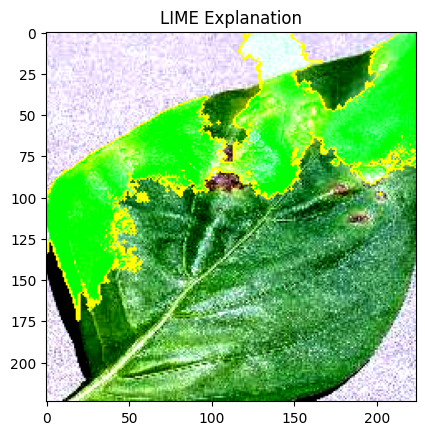

In [61]:
# @markdown Define a function to create a Lime explainer and explain predictions
"""
# @markdown &emsp;Now we are ready to define classification function that Lime needs.\
# @markdown &emsp;The input to this function is numpy array of images where each image is ndarray \
# @markdown &emsp;of shape (channel, height, width). The output is numpy aaray of shape \
# @markdown &emsp;(image index, classes) where each value in array should be probability for that \
# @markdown &emsp;image, class combination.
"""
preprocess_transform = transforms.Compose([
    transforms.Resize((dim, dim)),  # Resize images to a fixed size
    transforms.CenterCrop(crop_dim),     # Center crop to crop_dim * crop_dim pixels
    transforms.Normalize(mean=norm_mean, std=norm_std)  # Normalize
])
def batch_predict(images):
    model.eval()
    if len(images.shape) > 3: batch = torch.stack([preprocess_transform(torch.from_numpy(i).permute(2, 0, 1)) for i in images], dim=0)
    else: batch = preprocess_transform(torch.from_numpy(i)).permute(2, 0, 1).unsqueeze(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)

    logits = model(batch)
    probs = nn.Softmax(dim=1)(logits)
    return probs.detach().cpu().numpy()

def explain_lime(image, model, num_classes):
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(image, model, top_labels = num_classes)
    return explanation

# @markdown Choose an image to explain
image_no_for_input = 420 # @param {type:"integer"}
image, label = test_dataset[image_no_for_input]
explanation = explain_lime(image.permute(1, 2, 0).numpy(), batch_predict, num_classes)

# @markdown Visualize the Lime explanation
temp, mask = explanation.get_image_and_mask(
                                            label,
                                            positive_only=False,
                                            num_features=5,
                                            hide_rest=False
                                            )

plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), cmap='viridis')
plt.title('LIME Explanation')
plt.show()


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


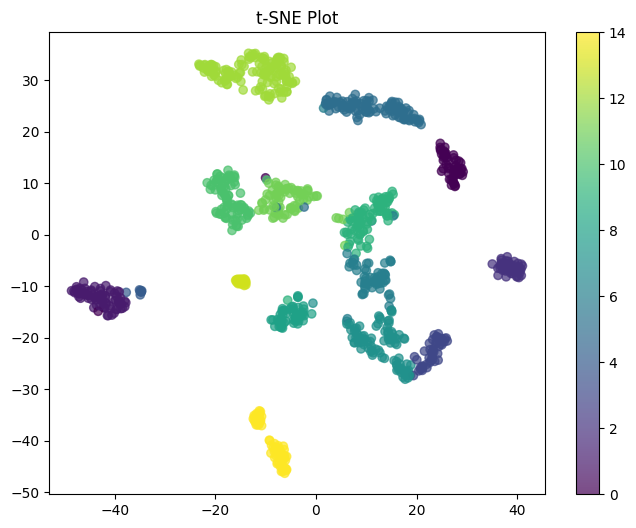

In [58]:
# @markdown Get feature representations for a subset of your data
num_samples = 1000  # @param {type:"integer"}
features = []
labels = []

model.eval()
with torch.no_grad():
    for inputs, batch_labels in test_loader:
        inputs = inputs.to(device)
        batch_labels = batch_labels.to(device)
        outputs = model(inputs)
        features.extend(outputs.cpu().numpy())
        labels.extend(batch_labels.cpu().numpy())

features = features[:num_samples]
labels = labels[:num_samples]

# @markdown Perform t-SNE
feat = np.stack(features)
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(feat)

# @markdown Visualize t-SNE plot
plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('t-SNE Plot')
plt.show()
